# EnvBayes Notebook #4.  Bayesian Sediment Geochronology

## Main Points
* The Bayesian inference engine is a convenient way to fit a model to data, and uncertainty and sensitivity evaluations come for free.
* The Bayesian model is extremely flexible and can therefore be tailored to unique problem considerations (e.g., combining measurement error and sampling error, and sharing information across data).  
* This notebook presents Bayesian lead 210 sedimentation model applied to a historical dataset from Puget Sound.  

## 1. Background and Purpose

### Background
Lead 210 is a naturally occurring radioactive isotope with a half-life of 22.3 years that is useful in geochronological dating of sediment.  Geochronological dating can be used to help answer many geoscientific questions, such as predicting the fate of contaminants in sediment.   

Lead 210 is a degradation product of atmospheric radon 222.  Lead 210 from the atmosphere binds to particulate matter and is deposited in sedimentary layers.  As sediment accumulates on the seafloor, lead 210 decays at a constant rate, resulting in an exponential decay curve of activity with sediment depth.  Therefore, the shape of the lead 210 curve in can help estimate the age of sediment at depth, and the average rate of deposition of fresh sediment.

Let's look at some plots to see what the curves look like.  

### Data

For demonstration purposes, I pulled data from a historical lead 210 study in Puget Sound from the 1980's documented in [Lavelle et. al. 1986](https://www.pmel.noaa.gov/pubs/PDF/lave732/lave732.pdf).  The old-timers did a great job of documenting their work, so it is a good example dataset.  I wrangled the data a bit from the original report to get a clean dataset.  

Imports and Plotting Functions

In [1]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import datetime
custom_params = {"axes.spines.right": False, "axes.spines.bottom": False}
sns.set_theme(style="ticks", rc=custom_params)
import pymc as pm
import arviz as az
pd.set_option('display.colheader_justify', 'center')

# data
data = pd.read_excel('data/lavelle_lead210_clean_2022-10-17.xlsx')
cols = data.columns[1:]
for col in cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')
    
cores = data.Core.unique()

# functions
def plot_core_ax(df, ax, x , y, title = 'Total Lead 210', ylabel = 'Depth (g/cm2)', unit = 'dpm/g', err_plot = False, legend=True):
 
    cores = df.Core.unique()
    if err_plot:
        err =  x+'_Err'
    else:
        err = 0
        
    for core in cores:
        df[df.Core==core].dropna(subset = [x]).plot(x = x, y= y, ax = ax, xerr = err)

    if df[x].min()>0:
        ax.set_xlim(0)
    
    if legend:
        ax.legend([core for core in cores], loc='upper center', bbox_to_anchor=(0.5, -0.05))
    else:
        ax.get_legend().remove()

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    
    ax.set_ylabel(ylabel)
    ax.set_xlabel(unit)
    ax.set_title(title)
    ax.invert_yaxis()

def plot_cores(cores, rows, cols, ylim = (250, 0), xlim = (0,15), figsize=(12, 6)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for ax, core in zip(axes.flatten(), cores):
        plot_core_ax(data[data.Core==core], ax, 'Pb210', 'Median_mass_g_cm2', 
                    title=core, legend=False, err_plot=True)
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)
    for ax in axes.flatten()[len(cores):]:
        ax.set_visible(False)
    plt.tight_layout()
    

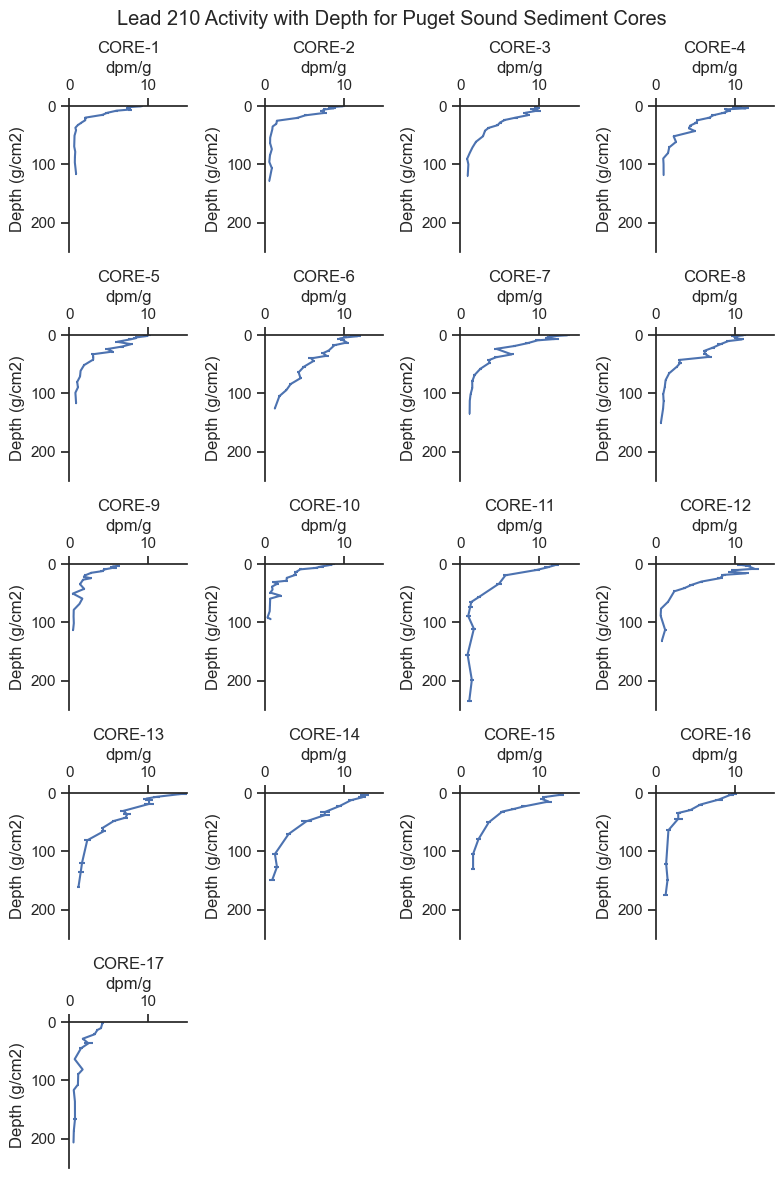

In [2]:
plot_cores(cores, 5, 4, figsize=(8, 12))
plt.suptitle('Lead 210 Activity with Depth for Puget Sound Sediment Cores')
plt.tight_layout()

There is a lot to point out in the trends above:     

* The x-axis is the lead 210 activity, which is measured in the laboratory.
* The y-axis is sediment depth corrected for density.  The figures are oriented in the same way as the sediment cores, with zero being the sediment - water interface and down on the plot being deeper in the sediment.  For reference, $1 \text{ } g/cm^2$ is about $2 \text{ }  cm$ depth.  
* We can see the lead 210 generally follows an exponential decay shape with higher concentrations in surface sediment and lower concentrations below. 
* Some cores have higher lead 210 activity at depth than others.  For example, Core 1 declines in activity quite rapidly, whereas Core 13 has elevated activity at depth.  Since lead 210 decays at a constant rate, we believe the Core 13 has younger sediment at depth compared to Core 1.  Therefore, Core 13 has a higher deposition rate.  
* Laboratory measurements of lead 210 include both the average activity measurement and the standard error of the measurement, which can be seen as small horizontal lines for some data points (e.g., Cores 16 and 17).  For many data points, the standard error of the measurement is about the width of the line so is not noticeable on the plot.  
* Notably, the lead 210 does not decay all the way to zero.  This is because there is another source of lead 210, referred to as supported lead 210, which comes from the surrounding geology rather than the atmosphere.  Excess lead 210, which is attributable to atmospheric sources, is the total lead 210 minus the supported lead 210.
* Some cores do not seem to reach the supported lead 210 level, such as Core 6, which is still declining at the mass-depth of $125\text{ }g/cm^2$  
* For many cores, the exponential decay shape is flatter near the surface sediment (i.e., $2 -10\text{ }g/cm^2$), attributable to mixing of surface sediments from critters (bioturbation) which brings fresher sediment deeper.  It is common to fit different curves near the surface and deeper in core profiles. 

Luckily, we know of a handy analytical model that can includes all nuances we observe in the data!  But first, let's define the problem statement.  

### Problem Statement
#### Purpose
The purpose of this analysis is to infer the physical properties of the sediment system (e.g., rate of deposition and mixing) based on lead 210 measurements in sediment cores and the understand the uncertainty in those inferences.  

#### Why Bayes?
The Bayesian inference algorithm is used to fit the model to the data.  The Bayesian approach can accomodate the non-linear physical-chemical model, different sources of error, and provides uncertainty modeling along the way.      

## 2. Model Description
### The Physical-Chemical Model

We will implement an analytical model developed by JM Abril in the undated paper *[Analytical solutions of the tracer-conservation equation in sediments, reviewed from the compaction potential theory: A unifying approach for radiometric dating models](https://www.researchgate.net/publication/266279845_Analytical_solutions_of_the_tracer-conservation_equation_in_sediments_reviewed_from_the_com-_paction_potential_theory_A_unifying_approach_for_radiometric_dating_models)*.  

The model accounts for the major physical and chemical processes that impact lead 210 in sediment: the loading of lead 210 from the atmosphere, the deposition and burial of sediment, the radioactive decay of leadn 210 in sediment, the mixing of surface sediment, and the concentration of lead 210 support.  Abril breaks up his partial differential equation into analytical parts that work for a steady-state condition.  I'll present them in Python only; see equations 19 and 20 in the [source document](https://www.researchgate.net/publication/266279845_Analytical_solutions_of_the_tracer-conservation_equation_in_sediments_reviewed_from_the_com-_paction_potential_theory_A_unifying_approach_for_radiometric_dating_models) for mathematical notation.  

The input parameters to the model are the following:  

* $phi$ is the excess lead 210 loading rate ($dpm/cm^2/yr$)
* $w$ is the sediment deposition rate ($g/cm^2/yr$)
* $ma$ is the depth of mixing ($g/cm^2$)
* $km$ is the coefficient of mixing ($g^2/cm^4/yr$)
* $\lambda$ is the decay rate for lead 210 ($0.031/yr$)
* $s$ is the lead 210 support ($dpm/g$)

The output of the model is:
* $A(m)$ is the lead 210 activity with depth ($dpm/g$) where:
* $m$ is the mass-depth of sediment (i.e., density-corrected depth) ($g/cm^2/yr$)

I input Abril's equations into Python and developed some functions that will plot the model curve, given some input parameters.

In [3]:
def A_calc_coeffs(w = 0.1,          # g/cm2/yr
            Phi = 10,               # dpm/cm2/yr
            ma = 5,                 # g/cm2
            km = 0.5,               # g2/cm4/yr
            lam = np.log(2)/22.3):  # yr
             
    xp = (w + (w**2 + 4 * lam * km)**(1/2))/(2 * km)
    xm = (w - (w**2 + 4 * lam * km)**(1/2))/(2 * km)
    eps = xm/xp*np.exp((xm-xp)*ma)
    Gamp = w - km * xp
    Gamm = w - km * xm
    Cm = Phi / (Gamm - eps * Gamp)
    Cp = - eps * Cm
    CII = (np.exp(xm*ma) - eps * np.exp(xp * ma) ) * Cm / np.exp(-lam*ma/w)
    
    return ma, xp, xm, Cm, Cp, CII, lam, w

def A_calc(m, ma, xp, xm, Cm, Cp, CII, lam, w, s):
    if m < ma:
        return Cp  * np.exp(xp * m) + Cm * np.exp(xm * m) + s
    if m >= ma:
        return CII * np.exp(-lam*m/w) + s

vect_A_calc = np.vectorize(A_calc)

def make_model_lines(
                        ylim=(250, 0),  # set up the mass depth array
                        w_prior = 0.2,                       # deposition rate g/cm2/yr
                        Phi_prior = .4,                       # loading rate dpm/cm2/yr
                        ma_prior = 7.5 ,                    # depth of mixing g/cm2
                        km_prior = 10,
                        support_prior = 1):
    mass_depth = np.linspace(ylim[1], ylim[0],200)
    # diffusion coefficient g2/cm4/yr
    ma, xp, xm, Cm, Cp, CII, lam, w  = A_calc_coeffs(w_prior, Phi_prior, ma_prior, km_prior)
    At = vect_A_calc(mass_depth, ma, xp, xm, Cm, Cp, CII, lam, w , support_prior)

    priors = pd.DataFrame()
    priors['mass_depth'] = mass_depth
    priors['At'] = At
    return priors

def plot_cores_w_model(cores, rows, cols, ylim, xlim, figsize, model_line_kwargs, alpha=1):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for ax, core in zip(axes.flatten(), cores):
        plot_core_ax(data[data.Core==core], ax, 'Pb210', 'Median_mass_g_cm2', 
                    title=core, legend=False, err_plot=True)
        make_model_lines(**model_line_kwargs).plot(
            ax = ax, x = 'At', y = 'mass_depth', color='black', alpha=alpha)
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)
        ax.set_xlabel('dpm/g')
        ax.get_legend().remove()
    for ax in axes.flatten()[len(cores):]:
        ax.set_visible(False)
    plt.tight_layout()

def annotated_core_example(model_line_kwargs):
    

    ylim = (60, 0)
    xlim = (0,25)
    fig, ax = plt.subplots()
    make_model_lines(**model_line_kwargs).plot(
                ax = ax, x = 'At', y = 'mass_depth', color='black', 
                #legend=False,
                label='Example Model Curve')
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.text(3, 8,
            'Surfacial mixing down to $ma$\nCurve shape influenced\nby mixing coefficient $km$',
           size=9)
    ax.text(10, 32, 
            'No mixing below $ma$\nCurve shape not influenced by $km$\nMore activity at depth = more deposition $w$',
           size=9)
    ax.axhline(model_line_kwargs['ma_prior'], linestyle=':', label='Depth of Mixing $ma$')
    ax.axvline(model_line_kwargs['support_prior'], linestyle='--', label='Support Level $s$')
    ax.set_xlabel('Activity of Lead 210', size=11)
    ax.set_ylabel('Mass Depth of Sediment',  size=11)
    ax.legend()
    ax.set_title('Annotated Example Model Curve\n')
    plt.tight_layout()

Let's get an intuitive feel for the model:

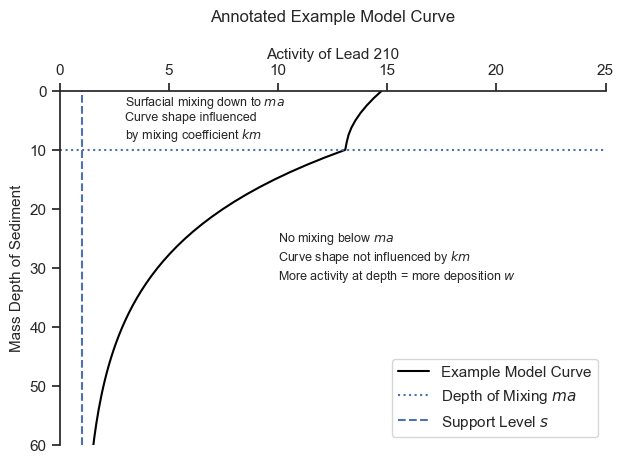

In [4]:
model_line_kwargs = {'Phi_prior':10, 'ma_prior':10,  'w_prior':0.5, 
                        'km_prior': 10, 'support_prior': 1}
annotated_core_example(model_line_kwargs)

The model will find the most appropriate mixing depth $ma$ and the best combination of the other parameters that approximate the trends above and below the mixing depth.  

After having a feel for the model, I played with the input parameters until they were in the right ballpark for all the cores.  Here is what the initial input parameters look like for all cores.    

In [5]:
model_line_kwargs = {'Phi_prior':12, 'ma_prior':5,  'w_prior':1.2, 
                    'km_prior': 10, 'support_prior': 0.7}

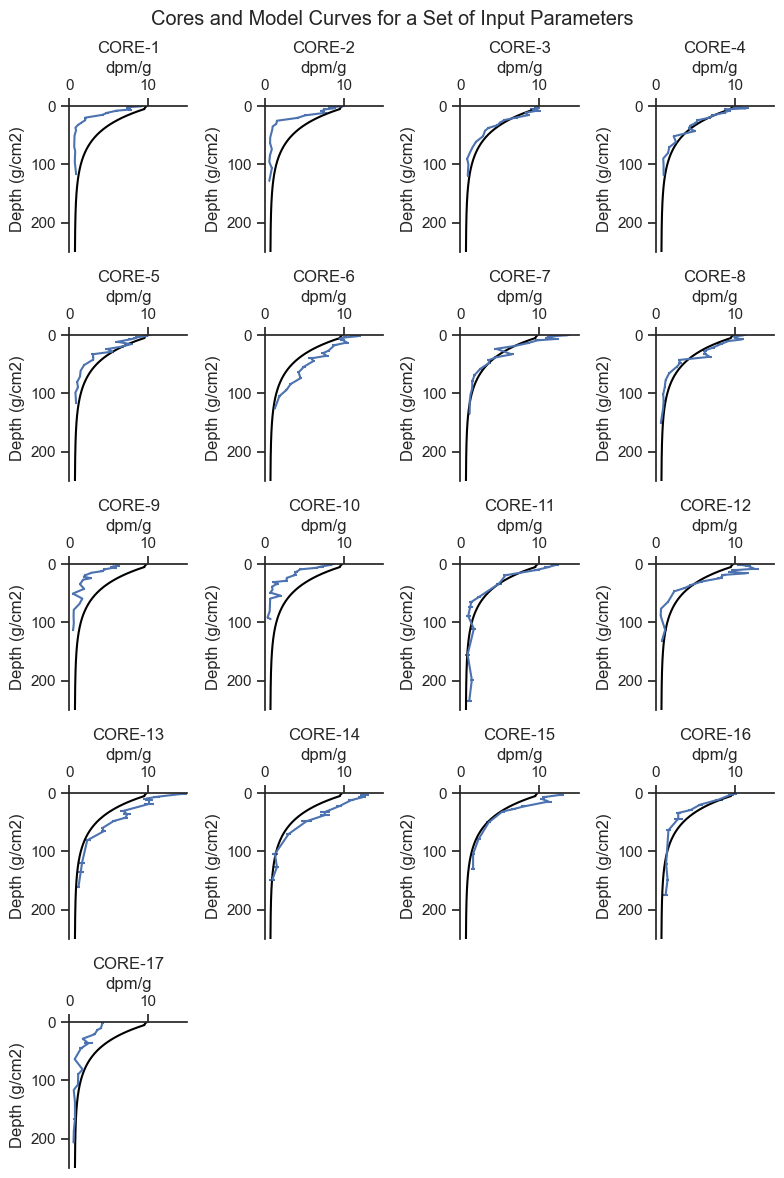

In [6]:
plot_cores_w_model(cores, rows=5, cols=4, ylim = (250, 0), xlim = (0,15), figsize=(8, 12),
                 model_line_kwargs=model_line_kwargs, alpha=1)
plt.suptitle('Cores and Model Curves for a Set of Input Parameters')
plt.tight_layout()

We can see that the shape of the model captures the general shape of the cores profiles and is in the general range of the results.  The initial parameters fit some cores are fit pretty well, and others are either a bit high or a bit low.  In any event, this is a reasonable starting place.      

Now, our goal is the fit these curves to the data.  To do so, we need to define prior distributions for input parameters and the likelihood function for the observed parameter.  

### Prior Distributions for Input Parameters

Five input parameters determine the shape of the lead 210 profile with depth.  We will use weakly informative priors which result in prior model predictions that are in the ballpark of the observed data, but be broad enough so that the data drives the results.  Based on our expert knowledge of the problem, two parameters will be shared by all cores, and three parameters will be unique to each core.  

The level of supported lead 210, $s$, and mixing coefficient, $km$, are assumed to be the same for all cores.  $s$ was observed to be similar for all the cores that reached the support level (i.e., the asymptote) at depth.  Moreover, some cores did not reach the support level, so it makes sense to combine this parameter for all cores.  $km$ only impacts the upper portion of the model curve, where there are few data points. In addition, the lead 210 profiles are not very sensitive to $km$, and unrealistic $km$ values can lead to model overfitting, so it is reasonable to combine the data for estimating $km$.   

The other parameters, $Phi$, $ma$, and $w$, are fit uniquely for each core and are of primary interest for the study.  

The model uses a gamma distribution as prior distributions for all parameters because it has positive-only support which ensures that the values are physically meaningful, and can be sufficiently broad to be weakly informative.  The prior gamma distributions will be specified with the prior means based on the initial values above and a standard deviation of half of those values (i.e., coefficient of variation of 0.5).  Here is the shape of the prior used for all parameters:    

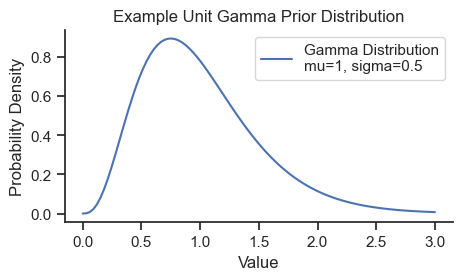

In [7]:
xs = np.linspace(0,3,100)
gamma = pm.Gamma.dist(mu=1, sigma=0.5)
prob = np.exp(pm.logp(gamma, xs).eval())
fig, ax = plt.subplots(figsize=(5,2.5))
ax.plot(xs, prob, label='Gamma Distribution\nmu=1, sigma=0.5')
sns.despine()
ax.set_title('Example Unit Gamma Prior Distribution')
ax.set_ylabel('Probability Density')
ax.set_xlabel('Value')
ax.legend();

The gamma distribution is often parameterized by shape and rate parameters, but here we use mean and standard deviation for simplicity. 

Prior predictive checks are shown in Appendix B, and a model with a broader prior specification is shown in Appendix C, both showing that this is a reasonable selection.  

### Likelihood Function

A normal likelihood function is used because the error of the data generally follow a normal distribution.  The mean of the likelihood function is the model-predicted activity $A$.  The standard deviation of the likelihood function is the addition of measurement error and sampling error.  The measurement error was provided by the laboratory for each sample.  The sampling error (i.e., additional error due to heterogeneity, naturally occuring randomness, or imperfect modeling specification), will be determined by the model for each core, since some cores appear to have more noise in the data than others.  The prior distribution for sampling error is a half normal distribution with a standard deviation of 1, considered weakly informative.    

### Complete Model Specification
We now arrive at the complete model specification!

In [8]:
# prior means
Phi_prior=10
ma_prior=5
w_prior=1
s_prior=0.7
lam = np.log(2)/22.3
km_prior = 10

# wrangle
fit_data = data.dropna(subset=['Pb210']).copy()
cores = fit_data.Core.unique()
core_idxs = list(range(len(cores)))
core_map = dict(zip(cores, core_idxs))
no_cores = len(fit_data.Core.unique())
fit_data['Core_idx'] = fit_data.Core.replace(core_map)
core_idx  = fit_data.Core_idx
x = fit_data.Median_mass_g_cm2.values
y = fit_data.Pb210.values
y_err =fit_data.Pb210_Err.values

Analytical model function.

In [9]:
def analytical_model(w, Phi, ma, km, s, core_idx, mass_depth):
    # analytical model equations - written to accept pymc variables
    xp = (w[core_idx] + (w[core_idx]**2 + 4 * lam * km)**(1/2))/(2 * km)
    xm = (w[core_idx] - (w[core_idx]**2 + 4 * lam * km)**(1/2))/(2 * km)
    eps = xm / xp * pm.math.exp((xm-xp)*ma[core_idx])
    Gamp = w[core_idx] - km * xp
    Gamm = w[core_idx] - km * xm
    Cm = Phi[core_idx] / (Gamm - eps * Gamp)
    Cp = - eps * Cm
    CII = (pm.math.exp(xm * ma[core_idx]) - eps * pm.math.exp(xp * ma[core_idx]) 
            ) * Cm / pm.math.exp(-lam  * ma[core_idx] / w[core_idx])
    
    # Ct is the prediction 
    # the switch functions uses the correct equation on either side of ma
    Ct = pm.math.switch(ma[core_idx] > mass_depth,
        Cp  * pm.math.exp(xp * mass_depth) + Cm * pm.math.exp(xm * mass_depth) + s,
        CII * pm.math.exp(-lam * mass_depth / w[core_idx]) + s)
    return Ct


The rest of the Bayesian model, including the data, priors, calls to the analytical model function, and the likelihood.  

In [10]:
model = pm.Model()
with model:
    # Data
    core_idx = pm.MutableData('core_idx', fit_data.Core_idx.values)
    mass_depth = pm.MutableData('mass_depth', fit_data.Median_mass_g_cm2.values )
    obs_pb210 = pm.MutableData('obs_pb210', fit_data.Pb210.values )
    measurement_err_pb210 = pm.MutableData('measurement_err_pb210', fit_data.Pb210_Err.values )

    # Priors
    w = pm.Gamma('w',     mu=w_prior,   sigma=w_prior/2,   shape=no_cores)
    ma = pm.Gamma('ma',   mu=ma_prior,  sigma=ma_prior/2,  shape=no_cores)
    Phi = pm.Gamma('Phi', mu=Phi_prior, sigma=Phi_prior/2, shape=no_cores)
    km = pm.Gamma('km',   mu=km_prior,  sigma=km_prior/2)
    s = pm.Gamma('s',     mu= s_prior,  sigma=s_prior/2)

    # Analytical model function from above
    A = analytical_model(w, Phi, ma, km, s, core_idx, mass_depth)
  
    # Sampling error - added to measurement error for each core
    sigma = pm.HalfNormal('sigma', sigma=1, shape=no_cores)  
    
    # Likelihood function based on A, measurement error, the sampling error
    # and the observed data.  
    pm.Normal('A_pred', mu=A, sigma=measurement_err_pb210 + sigma[core_idx],  
                       observed=obs_pb210)
model

     w ~ Gamma(4, f())
    ma ~ Gamma(4, f())
   Phi ~ Gamma(4, f())
    km ~ Gamma(4, f())
     s ~ Gamma(4, f())
 sigma ~ N**+(0, 1)
A_pred ~ N(f(ma, s, Phi, w, km), f(sigma))

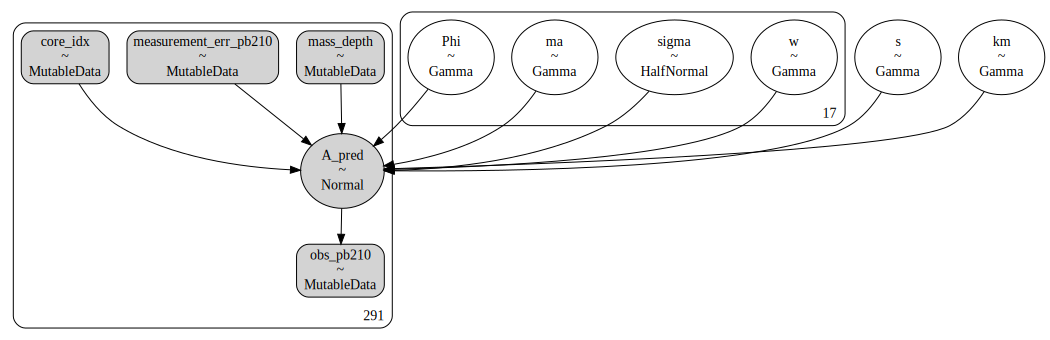

In [11]:
pm.model_to_graphviz(model)

The important thing to notice in the number at the bottom of the plate dimension of the variable.  For example, there are 17 $w$ variables - one for each core.  No plate indicates a shape of 1, so there is only one $s$ and $km$ variable shown on the diagram (consistent with the intended model specification).  There are 291 samples fit by the model. 

## 3. Results

Run the model.  

In [12]:
with model:
    trace = pm.sample(target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, ma, Phi, km, s, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 507 seconds.


In [13]:
def posterior_line_plot(x, y, trace, n, ax, core_idx, 
                   xmax = 25, core_no = 17,
                   title = 'title', 
             xlabel = 'Pb210XS_dpm_g',
             ylabel = 'Cum_Mass_Med_g_cm2', alpha=.1):
    
    ax.plot(y, x, 'o')  # data plot
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    mass_depth = np.linspace(0,xmax,500)
    random_idxs = np.random.choice(range(4000), n)
    for idx in random_idxs:
        ma, xp, xm, Cm, Cp, CII, lam, w  = A_calc_coeffs(
            w = trace.posterior['w'].values.reshape(4000, core_no)[:,core_idx][idx], 
            Phi = trace.posterior['Phi'].values.reshape(4000, core_no)[:,core_idx][idx],
            ma = trace.posterior['ma'].values.reshape(4000, core_no)[:,core_idx][idx], 
            km = trace.posterior['km'].values.reshape(4000)[idx],)
        At = vect_A_calc(mass_depth, ma, xp, xm, Cm, Cp, CII, lam, w, 
            s = trace.posterior['s'].values.reshape(4000)[idx])
        ax.plot(At , mass_depth,  c = 'black', alpha = alpha)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

    ax.set_title(title)
    ax.invert_yaxis()
    

def posterior_plot_grid(cores, rows, cols, ylim, xlim, figsize, n=50):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for ax, core in zip(axes.flatten(), cores):
        x = fit_data[fit_data.Core==core].Median_mass_g_cm2.values
        y = fit_data[fit_data.Core==core].Pb210.values
        posterior_line_plot(x,y,trace, n, ax, core_idx = core_map[core], title=core, xmax=250)
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)
        ax.set_ylabel('Depth (g/cm2)')
        ax.set_xlabel('dpm/g')
    for ax in axes.flatten()[len(cores):]:
        ax.set_visible(False)

Plot 50 samples from the posterior to see how well the posterior fit each core and get a sense for the uncertainty in the estimate.  

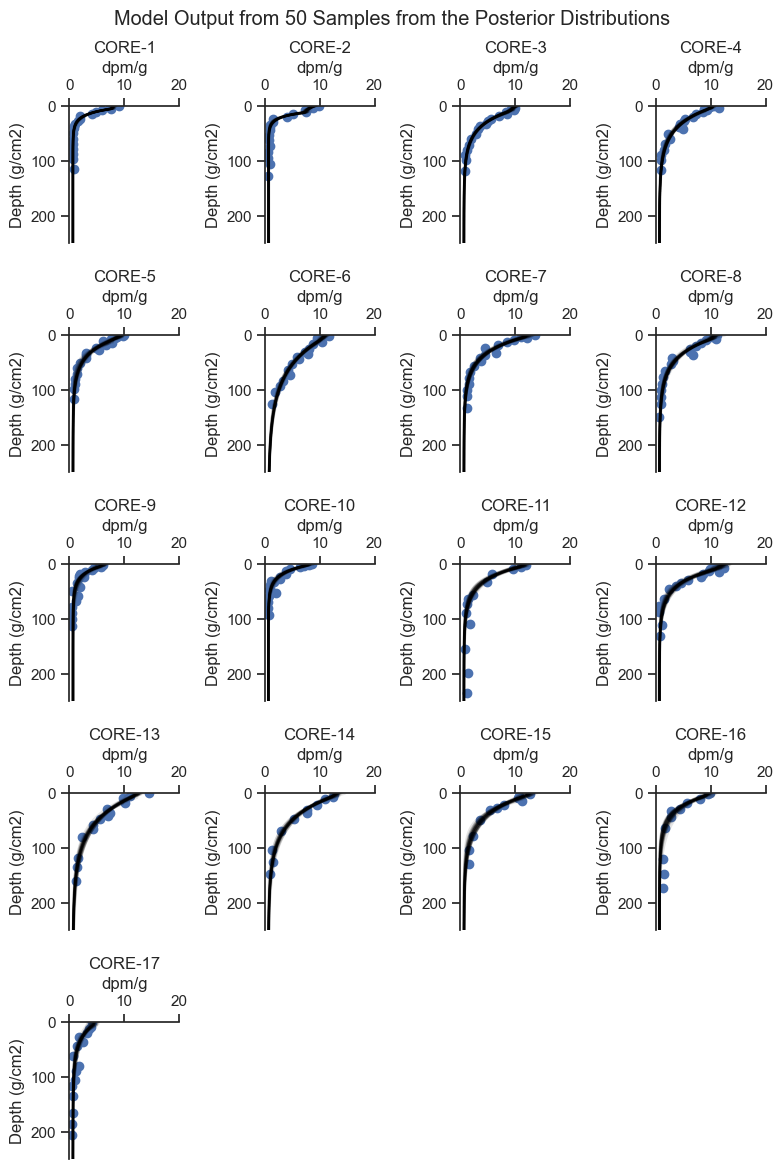

In [14]:
posterior_plot_grid(cores, rows=5, cols=4, ylim = (250, 0), xlim = (0,20), figsize=(8, 12), n=50)
plt.suptitle('Model Output from 50 Samples from the Posterior Distributions')
plt.tight_layout()

From the plots above, we can see that the model did a good job of fitting the shape of each core.  Let's look at the distribution of the deposition rate for each core, which is of primary importance to the analysis. 

In [15]:
labels = ['$w$ - Deposition rate (g/cm2/yr)',
            '$Phi$ - Lead 210 loading rate (dpm/cm2/yr)', 
            '$ma$ - Bioactive mixing depth (g/cm2)',  
            '$km$ - Bioactive mixing depth (g/cm4/yr)', 
            '$s$ - Support (dpm/g)',
            '$Sigma$ - Sampling error (dpm/g)']
var_names=[ 'w', 'Phi',  'ma', 'km', 's', 'sigma']
var_name = var_names[0]
var_name_dict = dict(zip(var_names, labels))

def posterior_plot(var_name, figsize=(8, 6)):
    axes = az.plot_posterior(trace, figsize = figsize, hdi_prob=.9,
            textsize=8,
            var_names=var_name)#, grid=(len(var_names), 1))
    xlim = max([ax.get_xlim()[1] for ax in axes.flatten()])
    for idx, ax in enumerate(axes.flatten()):
        ax.set_xlim(0, xlim)
        if ax.get_title():
            ax.set_title('')
            ax.set_title(cores[idx], loc='left')

    plt.suptitle(f'Posterior Distributions for {var_name_dict[var_name]}')
    plt.tight_layout()

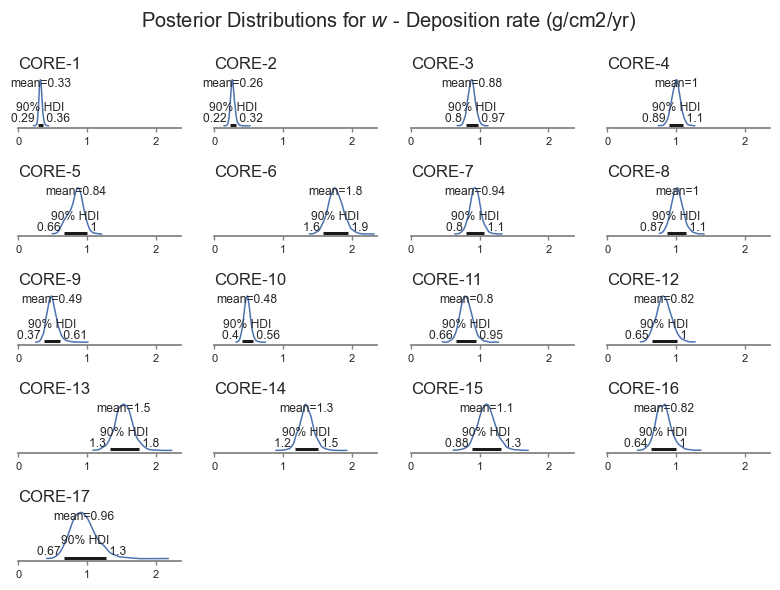

In [16]:
posterior_plot(var_name)

We can see that the deposition rate varies for each core, ranging between about 0.22 to 0.2 g/cm2/yr.  The model also picks up that some cores are more uncertain than others, based on the shape of the data.  

Mixing depth is also a key parameter of interest - shown in the next plot.  

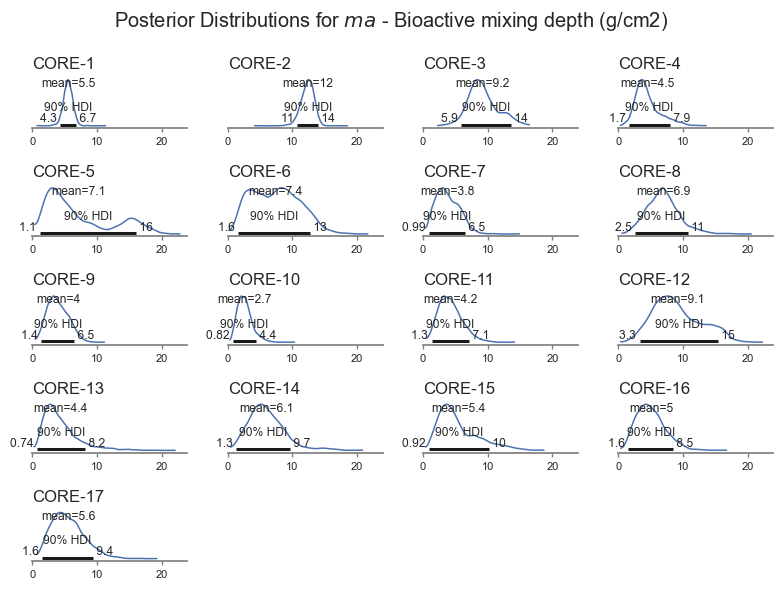

In [17]:
posterior_plot('ma')

The model is less sensitive to biological mixing depth, and it is therefore harder for the model to get right.  The Bayesian inference pick this up, resulting in wider uncertainty for $ma$.  The model also identifies cores for which the uncertainty is larger.  The model even picks up a bimodal distribution for Core-5 based on the trends in the data.  That core looks pretty interesting, let's look closer.  

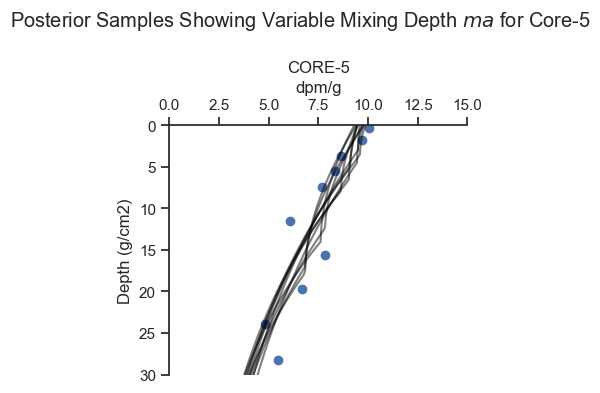

In [18]:
def posterior_plot_one(core, ylim, xlim, figsize, n=50):
    fig, ax = plt.subplots(figsize=figsize)
    
    x = fit_data[fit_data.Core==core].Median_mass_g_cm2.values
    y = fit_data[fit_data.Core==core].Pb210.values
    posterior_line_plot(x,y,trace, n, ax, core_idx = core_map[core], 
                        title=core, xmax=250, alpha=.5)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_ylabel('Depth (g/cm2)')
    ax.set_xlabel('dpm/g')

posterior_plot_one(cores[4],ylim = (30, 0), xlim = (0,15), 
                    figsize=(4, 4), n=10)
plt.suptitle('Posterior Samples Showing Variable Mixing Depth $ma$ for Core-5')
plt.tight_layout()

For Core-5, there are multiple viable ways to fit the data, as the inference algorithm picked up.  

## 4. Discussion

The Bayesian modeling framework is extremely flexible.  In this case, a non-linear set of equations were specified.  Of five equation input parameters, 2 were fit for all cores, and 3 were fit for each core, consistent with the scientific understanding of the system.  Measurement uncertainty was specified for each sample based on laboratory measurements, and sampling uncertainty (e.g., heterogeneity) was fit for each core.  The result is a coherent estimation for each core in one model.    

One of the noteworthy aspects to this analysis is that all the scientific logic is embedded in a single model that is fit once, whereas classical methods would be performed in many ad-hoc steps.  In this example, the classical might go something like this:
1. Disregard the measurement error except for plotting.
2. Calculate lead 210 support for each core based on a judgement about whether the support level was reached.  
3. For cores where the support level was not reached, perform an estimate and do a sensitivity evaluation later.  
4. Subtract out the support from the observed activity values.  
5. Identify the depth of mixing by eye.  
6. Perform linear regression in log space above and below the depth of mixing.
7. Present the least squares results, possibly with the confidence intervals around the least squares.  
8. Perform various permutations of sensitivity and uncertainty analyses.  

In each step along the way, the classical technique is easy to follow, but the final result is hard to reconstruct.  The Bayesian analysis is harder to set up initially, but much easier to reconstruct.             

## A. MCMC Diagnostics

The key diagnostic to show that the MCMC inference converged is the r_hat statistic, which measures the similarity between MCMC chains.  Based on the rule of thumb, the r_hat values should be all less than or equal to 1.01.  

The key diagnostic to show that the MCMC inference achieved sufficient resolution is the effective sample size (ESS) which is a measure of the MCMC samples adjusted for colinearity within the chain.  Based on a rule of thumb, the effective sample size should be greater than 400.  

We will pull the lowest effective sample sizes, which are generally going to be the parameters that were fit the worst by the model: 

In [19]:
var_names =[ 'w', 'Phi',  'ma', 'km', 's', 'sigma']
summary_df = az.summary(trace, var_names=var_names)[['r_hat', 'ess_bulk', 'ess_tail']]
summary_df.sort_values('ess_bulk').head(10)

,r_hat,ess_bulk,ess_tail
w[4],1.01,1030.0,1769.0
ma[4],1.01,1162.0,2725.0
sigma[4],1.00,1865.0,2063.0
s,1.00,2199.0,2931.0
Phi[4],1.00,2334.0,2428.0
w[14],1.00,2475.0,2386.0
w[2],1.00,2531.0,2785.0
w[0],1.00,2640.0,1849.0
ma[0],1.00,2705.0,1585.0
Phi[2],1.00,2741.0,2738.0


The variables are indexed by core index.  A quick scan of the output above shows that all values are within an acceptable range.  

Visual checks of the MCMC trace can help to identify potential issues in the MCMC sample.  The left-hand plots show the probability distributions for each variable and each chain to see if they coincide.  The right-hand plots show MCMC samples over time, which should look similar to white noise.  The MCMC sampler will also provide warning markers called "divergences" to help the practicioner to identify potential issues with the MCMC sample.  

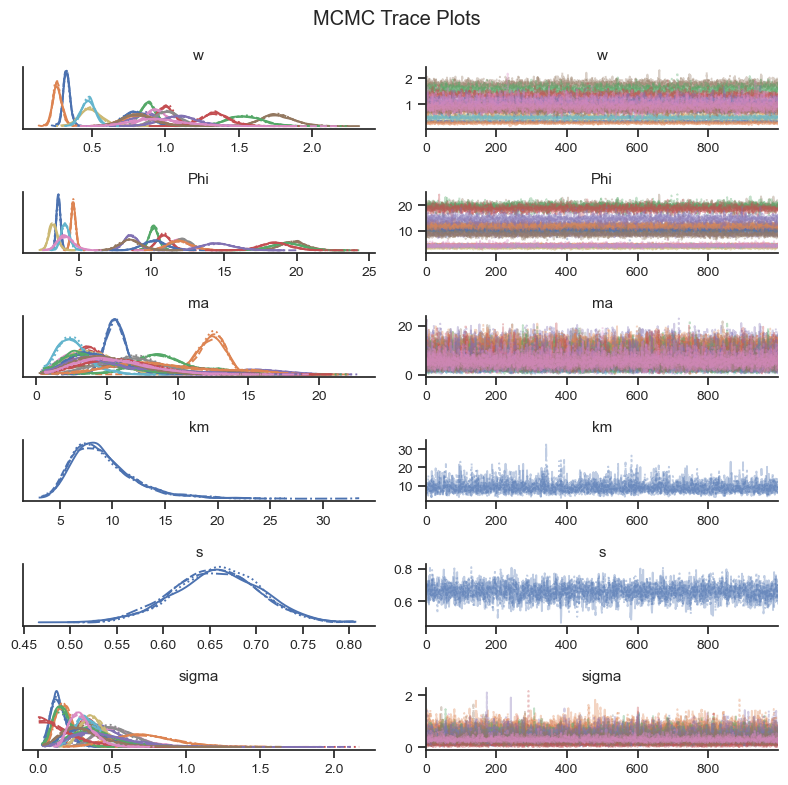

In [20]:
az.plot_trace(trace, var_names = var_names, figsize=(8,8))
plt.suptitle('MCMC Trace Plots')
sns.despine()
plt.tight_layout()

Based on the visual check of the trace plots above, the chains have converged and the sample explored the sample space. 

## B. Prior and Posterior Predictive Checks

### Prior Predictive Check

The prior predictive check helps to show that the selection of priors is in the range of the data and to identify if the prior is biasing the results.   

In [21]:
with model:
    prior = pm.sample_prior_predictive(50)

In [22]:
def make_model_lines(
                        ylim=(250, 0),  # set up the mass depth array
                        w = 0.2,                       # deposition rate g/cm2/yr
                        Phi = .4,                       # loading rate dpm/cm2/yr
                        ma = 7.5 ,                    # depth of mixing g/cm2
                        km = 10,
                        s = 1):
    mass_depth = np.linspace(ylim[1], ylim[0],200)
    # diffusion coefficient g2/cm4/yr
    ma, xp, xm, Cm, Cp, CII, lam, w  = A_calc_coeffs(w, Phi, ma, km)
    At = vect_A_calc(mass_depth, ma, xp, xm, Cm, Cp, CII, lam, w , s)

    priors = pd.DataFrame()
    priors['mass_depth'] = mass_depth
    priors['At'] = At
    return priors

def plot_cores_w_model(cores, rows, cols, ylim, xlim, figsize, model_line_kwargs_list, alpha=1):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for ax, core in zip(axes.flatten(), cores):
        plot_core_ax(data[data.Core==core], ax, 'Pb210', 'Median_mass_g_cm2', 
                    title=core, legend=False, err_plot=True)
        for model_line_kwargs in model_line_kwargs_list:
            make_model_lines(**model_line_kwargs).plot(
                ax = ax, x = 'At', y = 'mass_depth', color='black', alpha=alpha)
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)
        ax.get_legend().remove()
        for ax in axes.flatten()[len(cores):]:
            ax.set_visible(False)
    plt.tight_layout()

In [23]:
params = ['w','Phi','ma', 'km', 's']
prior_df = pd.DataFrame()
for param in params:
    values = prior.prior[param].values.flatten()
    if param == 's':
        values = list(values)*len(cores)
    elif param == 'km':
        values = list(values)*len(cores)
    prior_df[param] = values
prior_df;

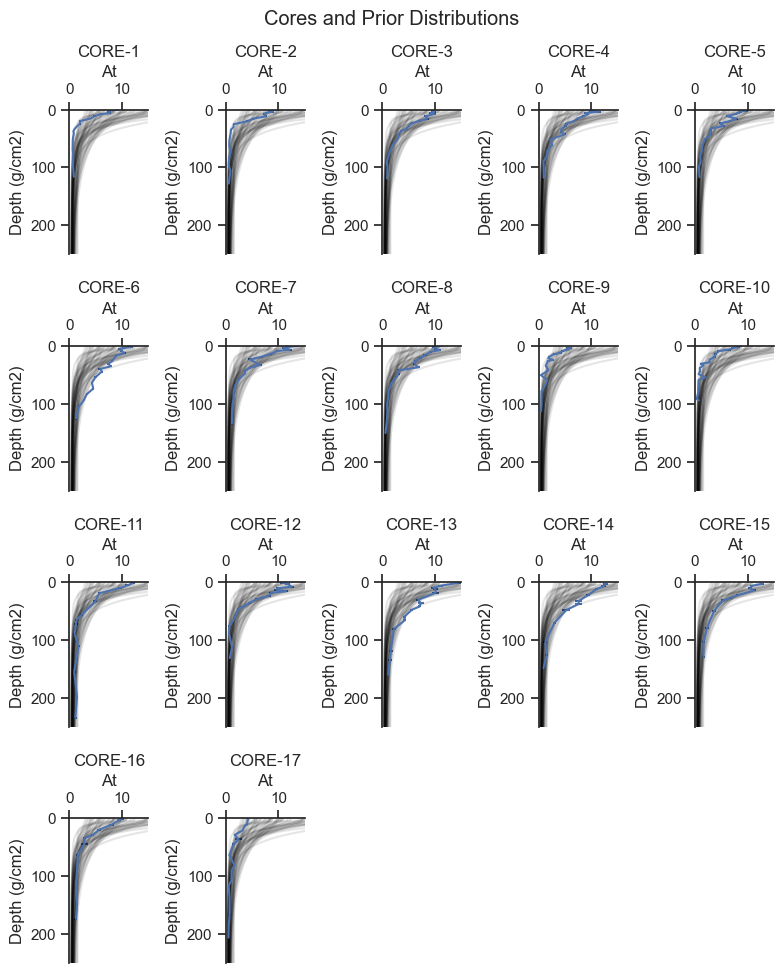

In [24]:
model_line_kwargs_list = [dict(prior_df.loc[i]) for i in range(50)]
plot_cores_w_model(cores, rows=4, cols=5, ylim = (250, 0), xlim = (0,15), figsize=(8, 10),
                 model_line_kwargs_list=model_line_kwargs_list, alpha=.1)
plt.suptitle('Cores and Prior Distributions')
plt.tight_layout()

Based on the plots above, the prior predictive covers the range of the data, consistent with weakly informative priors.  Wider priors will be compared in Appendix B.  

### Posterior Predictive Check

The posterior predictive check is where the fit model is used to general simulated data to see if it has similar characteristics to the observed data.  

The following graphic presents the range of posterior predicted values compared to the observed concentrations.  

In [25]:
with model:
    post_pred = pm.sample_posterior_predictive(trace)

In [26]:
pp_df = pd.DataFrame(post_pred.posterior_predictive.A_pred.values[0].T)
pp_df['Core'] = fit_data.Core.values
pp_df['Median_mass_g_cm2'] = fit_data.Median_mass_g_cm2.values
no = 3
draws = list(np.random.choice(np.linspace(0,1000,1001), size=3))
pp_df = pp_df[draws + ['Core', 'Median_mass_g_cm2']]

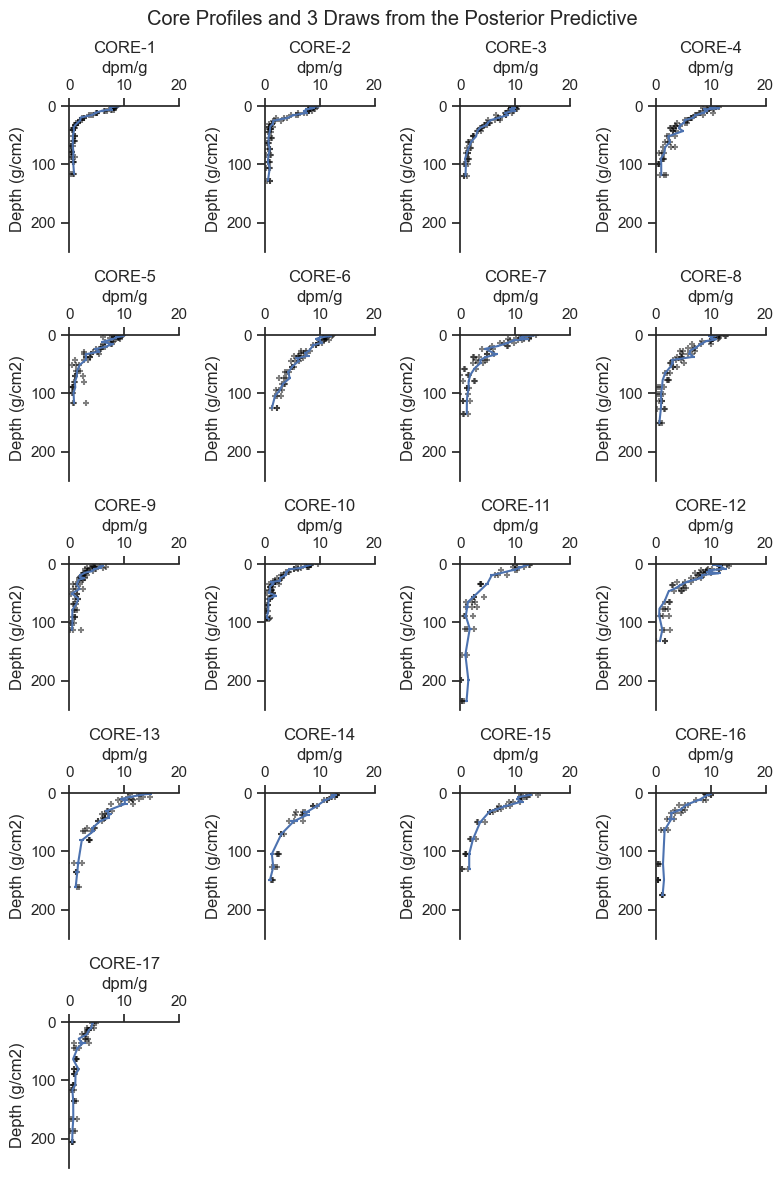

In [27]:
def plot_cores_w_predictive(cores, rows, cols, ylim, xlim, figsize, alpha=.01):
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    for ax, core in zip(axes.flatten(), cores):
        pp_df[pp_df.Core==core].melt(id_vars = ['Core', 'Median_mass_g_cm2']
            ).plot.scatter('value', 'Median_mass_g_cm2', 
                            ax=ax, color='black', alpha=alpha, 
                            marker = '+')
        plot_core_ax(data[data.Core==core], ax, 'Pb210', 'Median_mass_g_cm2', 
                    title=core, legend=False, err_plot=True)
        ax.set_ylim(ylim)
        ax.set_xlim(xlim)
    for ax in axes.flatten()[len(cores):]:
        ax.set_visible(False)
    plt.tight_layout()
        

plot_cores_w_predictive(cores, rows=5, cols=4, ylim = (250, 0), xlim = (0,20), 
                        figsize=(8, 12), alpha=.5)
plt.suptitle(f'Core Profiles and {no} Draws from the Posterior Predictive')
plt.tight_layout()

The data generated by the posterior predictive are reasonable based on the data.  You may be able to see that some cores have more noise added to the predictions than others, consistent with the shape of the data for each core.

One potential modification would be to make the error less for the deeper samples where the activity is less.  Let's look at the residuals and see if that would make sense.  

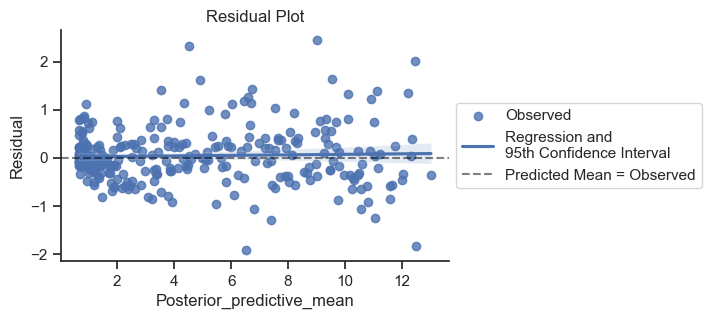

In [28]:
post_pred_means = post_pred.posterior_predictive.A_pred.values.reshape(4000, len(fit_data.Core_idx.values)).mean(axis=0)

fit_data['Posterior_predictive_mean'] = post_pred_means
fit_data['Residual']  =  fit_data.Pb210 - fit_data.Posterior_predictive_mean
fit_data.head()

fig, ax = plt.subplots(figsize=(5,3))
sns.regplot(data=fit_data, x = 'Posterior_predictive_mean', y='Residual',
            ax=ax, label='Observed' , 
            line_kws={'label':'Regression and\n95th Confidence Interval'})
sns.despine()
ax.axhline(0, linestyle='--', color='black', label='Predicted Mean = Observed', alpha=.5)
ax.legend(loc='center left', bbox_to_anchor=(1,.5))
ax.set_title('Residual Plot');

The error is a bit tighter on the left side of the plot, but good enough for our purposes.  

## C.  Sensitivity to Alternative Specifications

Many different permutations of the model to could be tried which change the structure of the model.  For example, having different values for $s$ nd $km$ for each core, or employing hierarchical priors for certain parameters.  The comparison below changes only to the width of the prior A wider prior specification is compared below.  

### Wider Prior Specification

Here is a model specified with wider prior parameter values based on a flat positive-only distribution (i.e., half-flat) for all five parameters.  

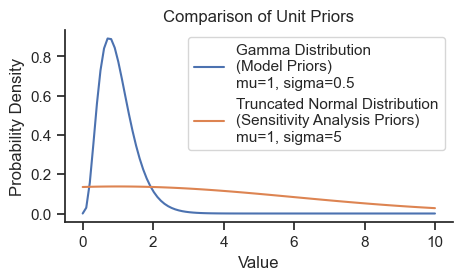

In [29]:
xs = np.linspace(0,10,100)
gamma = pm.Gamma.dist(mu=1, sigma=0.5)
prob = np.exp(pm.logp(gamma, xs).eval())
norm = pm.TruncatedNormal.dist(mu=1, sigma=5, lower=0)
prob_norm = np.exp(pm.logp(norm, xs).eval())

fig, ax = plt.subplots(figsize=(5,2.5))
ax.plot(xs, prob, label='Gamma Distribution\n(Model Priors)\nmu=1, sigma=0.5')
ax.plot(xs, prob_norm, label='Truncated Normal Distribution\n(Sensitivity Analysis Priors)\nmu=1, sigma=5')
sns.despine()
ax.set_title('Comparison of Unit Priors')
ax.set_ylabel('Probability Density')
ax.set_xlabel('Value')
ax.legend();

In [30]:
model = pm.Model()
with model:
    # data
    core_idx = pm.MutableData('core_idx', fit_data.Core_idx.values)
    mass_depth = pm.MutableData('mass_depth', fit_data.Median_mass_g_cm2.values )
    obs_pb210 = pm.MutableData('obs_pb210', fit_data.Pb210.values )
    measurement_err_pb210 = pm.MutableData('measurement_err_pb210', fit_data.Pb210_Err.values )

    # Priors
    w = pm.TruncatedNormal('w', mu=w_prior, sigma=w_prior/2, lower = 0, shape=no_cores)
    ma = pm.TruncatedNormal('ma', mu= ma_prior,sigma=ma_prior/2 , lower = 0, shape=no_cores)
    Phi = pm.TruncatedNormal('Phi', mu=Phi_prior, sigma=Phi_prior/2, lower = 0,  shape=no_cores)
    km = pm.TruncatedNormal('km', mu=km_prior, lower = 0, sigma=km_prior/2)
    s = pm.TruncatedNormal('s', mu= s_prior, lower = 0, sigma=s_prior/2)

    # analytical model
    A = analytical_model(w, Phi, ma, km, s, core_idx, mass_depth)
  
    # sampling error - added to measurement error for each core
    sigma = pm.HalfNormal('sigma', sigma=1, shape=no_cores)  
    
    # Likelihood (sampling distribution) of observations
    pm.Normal('A_pred', mu=A, sigma=measurement_err_pb210 + sigma[core_idx],  
                       observed=obs_pb210)

In [35]:
model

     w ~ TruncatedNormal(1, 0.5, 0, inf)
    ma ~ TruncatedNormal(5, 2.5, 0, inf)
   Phi ~ TruncatedNormal(10, 5, 0, inf)
    km ~ TruncatedNormal(10, 5, 0, inf)
     s ~ TruncatedNormal(0.7, 0.35, 0, inf)
 sigma ~ N**+(0, 1)
A_pred ~ N(f(ma, s, Phi, w, km), f(sigma))

In [32]:
with model:
    trace = pm.sample(target_accept=.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, ma, Phi, km, s, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1154 seconds.


The results are very similar with less informative priors:  

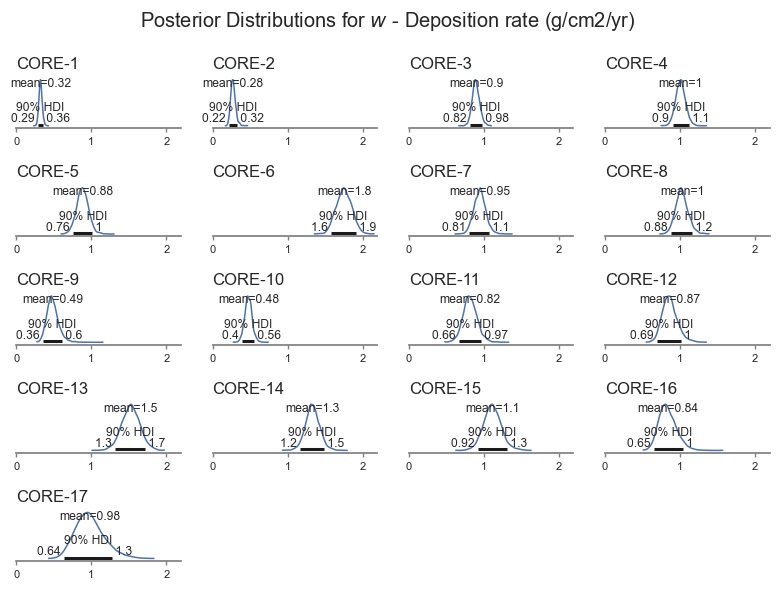

In [33]:
posterior_plot(var_name)

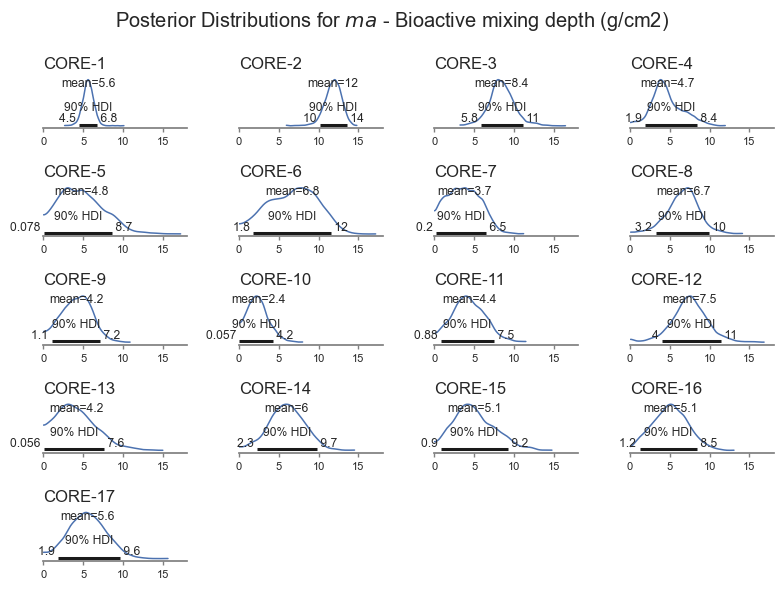

In [34]:
posterior_plot('ma')

The flatter priors generally gave similar results to the main analysis.  Given the range of results, the two analyses are roughly interchangeable.   

## Final Remarks
This notebook wrapped an analytical model equation within a Bayesian modeling framework that allowed the combination of multiple scientific considerations (e.g., sources or error, shared model parameters) into one coherent model.  Uncertainty could be quantified for all model parameters, even those that are highly non-linear, like mixing depth.  Diagnostic checks and a sensitivity analyses were used to verify the reasonableness of the results.      